In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from collections import OrderedDict
import argparse
import json
import pickle
from datetime import datetime
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import shap
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
#get directory
df_train_path = os.path.join('data','df_train_scaled.csv')
df_test_path = os.path.join('data','df_test_scaled.csv')


In [3]:
df_train = pd.read_csv(df_train_path, compression='zip',index_col=0)
df_train.head()

/ichec/home/users/ikunal95/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.610627,0.172191,-0.165071,-0.326720,1.125480,0.447761,-0.425631,-1.304639,0,-0.280449,...,0,-0.544925,-1.031547,-0.312756,0,-0.506174,0.167560,-1.295442,-0.664064,0.758198
67,1.637546,1.587155,-1.679589,-1.849610,-1.094865,2.003926,0.925331,-1.304639,1,-1.129757,...,0,0.049260,1.652931,0.182998,0,1.812689,-0.286453,0.005808,-1.141442,-0.946936
109,-0.610627,0.172191,-0.165071,-0.326720,-1.094865,-1.108404,0.376406,1.110298,0,-0.280449,...,0,-0.041656,1.167090,-0.808510,0,-0.404217,-0.657446,-1.125453,-0.504937,0.757704
166,-0.610627,0.052647,-0.165071,-0.174431,-1.372409,-1.108404,-1.962332,1.110298,0,-0.280449,...,0,-0.489803,-0.990374,-0.808510,0,-1.029029,0.458129,-0.588348,0.449820,0.696767
240,-0.610627,0.359114,-0.165071,-0.479009,-1.094865,-1.108404,-0.040973,1.110298,0,-0.705103,...,0,-0.102644,0.117179,-0.808510,0,0.016681,-0.199473,-1.212870,-0.823190,0.854260


In [4]:
df_test = pd.read_csv(df_test_path, compression='zip', index_col=0)
df_test.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.570976,-1.294606,1.356055,1.209613,0.855221,-0.986772,-0.544575,1.124050,0,1.508179,...,0,-0.840577,-2.343674,0.966999,0,0.607537,-1.476305,-1.426077,2.234328,-0.036477
78,-0.570976,-0.275277,0.592659,0.284735,1.131238,0.689685,-0.192022,-1.305284,0,2.829991,...,0,0.911808,0.468075,0.522267,0,0.561519,-0.285751,-0.499703,0.552829,0.483092
83,-0.570976,-0.835469,0.592659,0.901320,1.131238,0.689685,1.292035,1.124050,0,-0.254237,...,0,0.234027,-0.562625,0.966999,0,0.946541,0.340857,0.862879,0.889129,0.194849
123,-0.570976,2.336756,-1.697530,-1.565023,1.131238,-0.986772,0.766151,-1.305284,0,-0.254237,...,1,-0.663703,-0.356485,0.077535,1,0.315703,-1.382314,-1.716246,-0.960519,1.909040
144,1.751298,-0.275277,0.592659,0.284735,-0.524867,0.689685,-0.257746,-1.305284,1,0.626971,...,0,-0.562148,-1.547974,0.077535,0,-0.174013,0.340857,0.792449,2.234328,-2.141528


In [5]:
df_fico_grade = pd.read_csv('data/grade_to_fico.csv')
df_fico_grade.head()

,sub_grade,score,value
0,A1,789,34
1,A2,780,33
2,A3,769,32
3,A4,761,31
4,A5,741,30


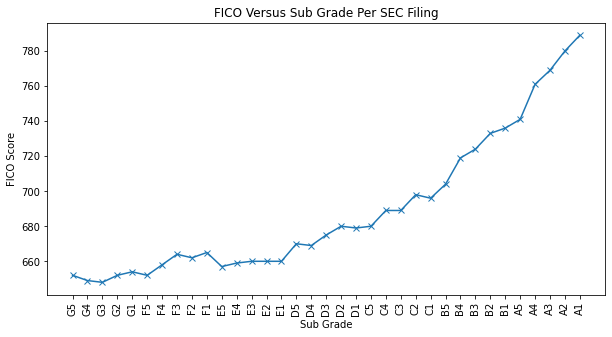

In [6]:
plt.figure(figsize=(10,5))
plt.plot(df_fico_grade['value'], df_fico_grade['score '], marker='x')
plt.xticks(range(df_fico_grade.shape[0]) , df_fico_grade['sub_grade'][::-1], rotation='vertical')
plt.xlabel('Sub Grade')
plt.ylabel("FICO Score")
plt.title("FICO Versus Sub Grade Per SEC Filing")
plt.savefig(os.path.join('plots','fico_grade_line.png'))
plt.show()

In [7]:
#instantiate regressor
knn = KNeighborsRegressor(n_neighbors=1)
#fit to data
knn.fit(np.reshape(df_fico_grade['score '].values, (-1, 1)), 
        df_fico_grade['value'])
#make sample prediction
knn.predict(np.reshape([750], (1,-1)))[0]

30.0

In [8]:
#save the model
with open(os.path.join('models', 'knn_regression.pkl'), 'wb') as handle:
    pickle.dump(knn,handle)

In [9]:
df_fico_apr = pd.read_csv('data/grade_to_apr.csv')
df_fico_apr.head()

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.30
1,33,A2,6.97,7.99,8.26
2,32,A3,7.62,8.99,8.91
3,31,A4,8.60,9.98,9.91
4,30,A5,9.25,10.99,10.56


In [10]:
df_fico_apr[df_fico_apr['grade_num']==30]['36_mo']

4    10.99
Name: 36_mo, dtype: float64

In [11]:
#target variable
target_col = 'loan_status'

#training variables
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

#test variables
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [12]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1,
                           scale_pos_weight=estimate)

clf.fit(X_train, y_train)

#make predictions
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

Estimate: 4.020


array([[91648, 48882],
       [19700, 33978]])

In [13]:
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1],pos_label=1)

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       clf.predict_proba(X_test)[:,1],
                                                       pos_label=1)

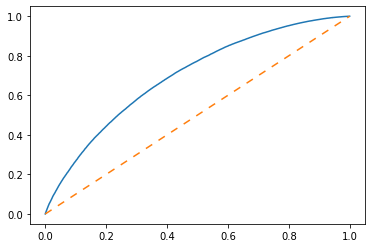

In [15]:
plt.plot(fpr, tpr, label='XGB')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

In [16]:
xgb_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print("xgb_auc: {}".format(xgb_auc))

xgb_auc: 0.6974718506889389


In [17]:
f1_xgb = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_xgb))
print(classification_report(y_test,y_pred))

f1_xgb (binary): 0.497707597884838

              precision    recall  f1-score   support

           0       0.82      0.65      0.73    140530
           1       0.41      0.63      0.50     53678

    accuracy                           0.65    194208
   macro avg       0.62      0.64      0.61    194208
weighted avg       0.71      0.65      0.66    194208



In [18]:
#define location to save trained model
save_model_dir = os.path.join('models','xgb_cv_compact.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)

Saving model at: models/xgb_cv_compact.pkl


In [19]:
#get input
fico = 800
loan_amnt = 1000
term = '36 months'
dti = 2
home_ownership = 'rent'
mort_acc = 5
annual_inc = 50_000
open_acc = 5
employment = 'nurse'
verification_status = 1
revol_util = 60
application_type = 0
total_acc=1


In [20]:
#calculate grade from FICO
sub_grade = knn.predict(np.reshape([fico], (1,-1)))[0]
#calculate grade
grade = round(sub_grade/5) + 1
#get interest rate
apr_row = df_fico_apr[df_fico_apr['grade_num']==sub_grade]


In [21]:
apr_row

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.3


In [22]:
if term=='36 months':
    int_rate = apr_row['36_mo'].values[0]
    installment = float(loan_amnt)/36
            
else:
    int_rate = apr_row['60_mo'].values[0]
    installment = float(loan_amnt)/60

In [23]:
term_to_int = {'36 months': 1, '60 months': 2}
home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }

In [24]:
X_train.columns

Index(['term', 'sub_grade', 'home_ownership', 'annual_inc',
       'verification_status', 'dti', 'revol_util', 'mort_acc', 'credit_hist',
       'credit_line_ratio', 'balance_annual_inc', 'fico_avg_score',
       'inst_amnt_ratio'],
      dtype='object')

In [25]:

feature_list=['term','sub_grade','home_ownership', 'annual_inc', 'verification_status',
       'dti','revol_util', 'mort_acc','credit_hist', 'credit_line_ratio',
       'balance_annual_inc', 'fico_avg_score', 'inst_amnt_ratio']


In [26]:
temp = pd.DataFrame(index=[1])
temp['term']=term_to_int[term]
temp['sub_grade']=sub_grade
temp['home_ownership']=home_to_int[home_ownership.upper()]
temp['annual_inc']=np.log(annual_inc)
temp['verification_status']=verification_status
temp['dti']=dti
temp['revol_util']=revol_util
temp['mort_acc'] = mort_acc
temp['credit_hist']=20
temp['credit_line_ratio']=open_acc/total_acc
temp['balance_annual_inc']=loan_amnt/annual_inc
temp['fico_avg_score'] = fico
temp['inst_amnt_ratio']=installment/loan_amnt

In [27]:
temp

,term,sub_grade,home_ownership,annual_inc,verification_status,dti,revol_util,mort_acc,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
1,1,34.0,3,10.819778,1,2,60,5,20,5.0,0.02,800,0.027778


In [28]:
df_macro_mean  = pd.read_csv('data/df_macro_mean.csv', index_col=0)
df_macro_std = pd.read_csv('data/df_macro_std.csv', index_col=0)    

In [29]:
drop_columns=['emp_length','purpose','revol_bal','grade','int_rate']

df_macro_mean=df_macro_mean.drop(columns=drop_columns)
df_macro_std =df_macro_std.drop(columns=drop_columns)

In [30]:
scale = temp.copy()
code=23
for feat in df_macro_mean.columns:
    scale[feat] = (scale[feat] - df_macro_mean.loc[code,feat]) / df_macro_std.loc[code,feat]
scale.head()

,term,sub_grade,home_ownership,annual_inc,verification_status,dti,revol_util,mort_acc,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
1,-0.653633,1.682293,-1.22267,-0.559224,-0.136527,-2.028323,0.179252,1.329428,-2.352922,26.964008,-1.79369,3.400047,-0.670827


In [31]:
clf.predict(scale)[0]

0